# How first-time airbnb users decide where to travel
***

New users on Airbnb can book a place to stay in 34,000+ cities across 190+ countries. By accurately predicting where a new user will book their first travel experience, Airbnb can share more personalized content with their community, decrease the average time to first booking, and better forecast demand.

Airbnb challenges you to predict in which destination country a new user from the USA will make his or her first booking:
1. United States of America
2. France
3. Canada
4. Great Britain
5. Estonia
6. Italy
7. Portugal
8. Netherlands
9. Germany
10. Australia  
11. No Destination Found (NDF) 
12. Other


Questions that I would like to explore using the summary data provided are:
1. Are there missing data or data munging that need to be done?
2. Are there any outliers?
3. What are the similarities/differences in the destination countries?
4. Demographic differences that could point to preferences?
5. Investigate the impact that user interaction with the website has on destination selection.


## Known Issues
1. before early 2013 users could make bookings without creating an account
2. where date_fisrt_booking is populated with nana the destination country is also given as NDF


## Evaluation

The evaluation metric for this competition is [NDCG (Normalized discounted cumulative gain)](https://www.kaggle.com/wiki/NormalizedDiscountedCumulativeGain) @k where k=5. NDCG is calculated as:

$$DCG_k=\sum_{i=1}^k\frac{2^{rel_i}-1}{\log_2{\left(i+1\right)}},$$

$IDCG_k$ is the maximum possible (ideal) $DCG$ for a given set of queries, documents, and relevances. All NDCG calculations are relative values on the interval 0.0 to 1.0.

$$nDCG_k=\frac{DCG_k}{IDCG_k},$$

For each new user, you are to make a maximum of 5 predictions on the country of the first booking. The ground truth country is marked with relevance = 1, while the rest have relevance = 0.

For example, if for a particular user the destination is FR, then the predictions become:

[ FR ]  gives a $NDCG=\frac{2^{1}-1}{log_{2}(1+1)}=1.0$

[ US, FR ] gives a $DCG=\frac{2^{0}-1}{log_{2}(1+1)}+\frac{2^{1}-1}{log_{2}(2+1)}=\frac{1}{1.58496}=0.6309$

## Act II: Confrontation
There is a singificant difference between the expected visit pattterns of the USA Citizen and that of airbnb. Further, there looks to be another difference in the sample given for training to that of the airbnb 2015 userbase.

## Act III: Resolution



***
***
## Data Exploration

Questions that I would like to explore using the summary data provided are:
1. Are there missing data or dat munging that need to be done?
2. Are there any outliers?
3. What are the similarities/differences in the destination countries?
4. Demographic differences that could point to preferences?
5. Investigate the link with how/ and for how long a user interacts with the website has on destination selection.

In [86]:
# load libraries that will be used
%matplotlib inline

import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

from mpl_toolkits.basemap import Basemap

# make figures better:
font = {'weight':'normal','size':20}
plt.rc('font', **font)
plt.rc('figure', figsize=(9.0, 6.0))
plt.rc('xtick.major', pad=10) # xticks too close to border!
plt.style.use('ggplot')
#print(plt.style.available)

In [2]:
# unzip and read data

# Dataset #1: Countries to visit
zf = zipfile.ZipFile('data/countries.csv.zip')
countries = pd.read_csv(zf.open('countries.csv'))

# Dataset #2: Compare demographic distributions within destination countries
zf = zipfile.ZipFile('data/age_gender_bkts.csv.zip')
country_demographics = pd.read_csv(zf.open('age_gender_bkts.csv'))

# Dataset #3: User interactions on airbnb website
zf = zipfile.ZipFile('data/sessions.csv.zip')
user_sessions = pd.read_csv(zf.open('sessions.csv'))

# Dataset #4: Comparing test and training data to what has been provided as user data for 2015
# train
zf = zipfile.ZipFile('data/train_users_2.csv.zip')
train = pd.read_csv(zf.open('train_users_2.csv'))

# test
zf = zipfile.ZipFile('data/test_users.csv.zip')
test = pd.read_csv(zf.open('test_users.csv'))

# concatenate train- and test users together for total sample
users = pd.concat((train, test), axis=0, ignore_index=True)

### Dataset #1: Nine Potential Countries to Visits 

In [3]:
print("Rows: %0.0f; Columns: %0.0f" % np.shape(countries))
countries.head(10)

Rows: 10; Columns: 7


,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675,eng,0.00


***
### Dataset #2: Compare demographic distributions within destination countries 

In [4]:
# unzip and read user age and gender data
zf = zipfile.ZipFile('data/age_gender_bkts.csv.zip')
demographics = pd.read_csv(zf.open('age_gender_bkts.csv'))

In [5]:
print("Rows: %0.0f; Columns: %0.0f" % np.shape(demographics))
demographics.head()

Rows: 420; Columns: 5


,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1,2015
1,95-99,AU,male,9,2015
2,90-94,AU,male,47,2015
3,85-89,AU,male,118,2015
4,80-84,AU,male,199,2015


In [6]:
#get a better feel for the underlying values:
for column in demographics[['age_bucket','country_destination','gender','year']]:
    print(demographics[column].unique())

['100+' '95-99' '90-94' '85-89' '80-84' '75-79' '70-74' '65-69' '60-64'
 '55-59' '50-54' '45-49' '40-44' '35-39' '30-34' '25-29' '20-24' '15-19'
 '10-14' '5-9' '0-4']
['AU' 'CA' 'DE' 'ES' 'FR' 'GB' 'IT' 'NL' 'PT' 'US']
['male' 'female']
[ 2015.]


So it looks like this dataset is a summary of gender and age band per country of users for 1 year, 2015.

But what else can it tell us?

C:\Miniconda\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


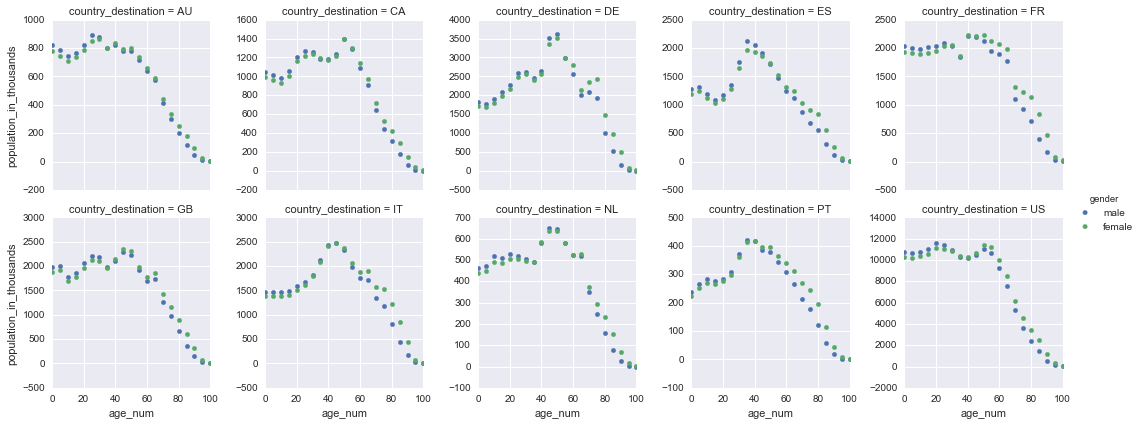

In [7]:
country_demographics['age_num'] = country_demographics['age_bucket'].map(lambda x: int(x[:str.find(x,'-')]))

g = sns.FacetGrid(country_demographics, col="country_destination", hue="gender", 
                    col_wrap=5, xlim=[0,100] ,sharey=False)
g = g.map(plt.scatter, "age_num", "population_in_thousands")
g.add_legend();

### Dataset #3: User Sessions 

In [9]:
print("Rows: %0.0f; Columns: %0.0f" % np.shape(user_sessions))
user_sessions.tail()

Rows: 10567737; Columns: 6


,user_id,action,action_type,action_detail,device_type,secs_elapsed
10567732,9uqfg8txu3,dashboard,view,dashboard,Windows Desktop,556
10567733,9uqfg8txu3,edit,view,edit_profile,Windows Desktop,6624
10567734,9uqfg8txu3,webcam_upload,-unknown-,-unknown-,Windows Desktop,200125
10567735,9uqfg8txu3,active,-unknown-,-unknown-,-unknown-,17624
10567736,9uqfg8txu3,show_personalize,data,user_profile_content_update,Windows Desktop,1221


In [10]:
top_tail = user_sessions[user_sessions.user_id.isin(['d1mm9tcy42','9uqfg8txu3'])].sort_values('action')
top_tail.groupby(['user_id','action','action_type','action_detail']).count()

device_type  \
user_id    action                      action_type      action_detail                              
9uqfg8txu3 active                      -unknown-        -unknown-                              2   
           callback                    partner_callback oauth_response                         1   
           create                      submit           create_phone_numbers                   2   
           dashboard                   view             dashboard                              1   
           edit                        view             edit_profile                           4   
           header_userpic              data             header_userpic                         1   
           languages_multiselect       -unknown-        -unknown-                              1   
           show                        view             user_profile                           1   
           show_personalize            data             user_profile_content_update            1   
           update                      submit           update_user_profile                    1   
           webcam_upload               -unknown-        -unknown-                              1   
d1mm9tcy42 active                      -unknown-        -unknown-                              1   
           ajax_refresh_subtotal       click            change_trip_characteristics            8   
           ask_question                submit           contact_host                           1   
           decision_tree               -unknown-        -unknown-                              1   
           faq_experiment_ids          -unknown-        -unknown-                              1   
           header_userpic              data             header_userpic                         1   
           hosting_social_proof        -unknown-        -unknown-                              2   
           index                       view             view_search_results                   11   
           multi                       -unknown-        -unknown-                              1   
           other_hosting_reviews_first -unknown-        -unknown-                              1   
           personalize                 data             wishlist_content_update               25   
           recent_reservations         -unknown-        -unknown-                              1   
           search_results              click            view_search_results                   12   
           show                        view             p3                                    14   
           similar_listings            data             similar_listings                       9   

                                                                                     secs_elapsed  
user_id    action                      action_type      action_detail                              
9uqfg8txu3 active                      -unknown-        -unknown-                               2  
           callback                    partner_callback oauth_response                          0  
           create                      submit           create_phone_numbers                    2  
           dashboard                   view             dashboard                               1  
           edit                        view             edit_profile                            4  
           header_userpic              data             header_userpic                          1  
           languages_multiselect       -unknown-        -unknown-                               1  
           show                        view             user_profile                            1  
           show_personalize            data             user_profile_content_update             1  
           update                      submit           update_user_profile                     1  
           webcam_upload               -unknown-        -unknown-                   

In [12]:
sessions_nan = user_sessions.replace('-unknown-', np.nan)
sessions_nan_counts = sessions_nan.isnull().sum().sort_values(ascending=False)
sessions_nan_summary = (sessions_nan_counts / sessions_nan.shape[0]) * 100

print('Number  of rows with missing values')
print('-------------------------------------')
print(sessions_nan_counts)

print('% of rows with missing values')
print('-------------------------------------')
print(sessions_nan_summary)

Number  of rows with missing values
-------------------------------------
action_type      2157374
action_detail    2157345
device_type       211279
secs_elapsed      136031
action             79626
user_id            34496
dtype: int64
% of rows with missing values
-------------------------------------
action_type      20.414721
action_detail    20.414446
device_type       1.999283
secs_elapsed      1.287229
action            0.753482
user_id           0.326428
dtype: float64


The session data seems to hold a rich variety of metrics, but the aren't really well populated for action type and action detail. And it would seems like unknowns in action type would also mean unknwons in actiona detail. But do I care about these fields?

In [13]:
# What values do action types tend to hold?
sessions_action_types = (user_sessions.action_type.value_counts() / user_sessions.shape[0]) * 100 
sessions_action_types

view                33.695975
data                19.907479
click               18.889408
-unknown-            9.757718
submit               5.898680
message_post         0.824235
partner_callback     0.181042
booking_request      0.177644
modify               0.010778
booking_response     0.000038
Name: action_type, dtype: float64

In [14]:
# top 20 action details
sessions_action_details = (user_sessions.action_detail.value_counts() / user_sessions.shape[0]) * 100 
sessions_action_details.head(20)

view_search_results            16.814243
p3                             13.025968
-unknown-                       9.757444
wishlist_content_update         6.688509
user_profile                    6.215512
change_trip_characteristics     4.615406
similar_listings                3.450351
user_social_connections         3.187049
update_listing                  2.552855
listing_reviews                 2.545682
dashboard                       1.447349
user_wishlists                  1.444699
header_userpic                  1.342104
message_thread                  1.252823
edit_profile                    1.028470
message_post                    0.824235
contact_host                    0.766872
unavailable_dates               0.736156
confirm_email_link              0.552834
create_user                     0.519298
Name: action_detail, dtype: float64

As the name suggests, there is more detail under the Action Detail field about the action performed but very little other than the occurance of reservation as a description pops out as relevant. Action Type looks like it should be the most promising of the 3 action related fields, because of the direct mention of booking request and booking response. So let's take a closer look.

In [15]:
user_sessions[user_sessions.action_type.isin(['booking_request','booking_response'])] \
.groupby(['action_type','action','action_detail']).count()

user_id  device_type  \
action_type      action        action_detail                         
booking_request  at_checkpoint at_checkpoint     5166         5170   
                 pending       pending          13596        13603   
booking_response booking       booking              4            4   

                                              secs_elapsed  
action_type      action        action_detail                
booking_request  at_checkpoint at_checkpoint          5128  
                 pending       pending               13521  
booking_response booking       booking                   4

It seems action and action details both hold the same information for these two booking related action types. When I looked at whether I can used the occurance of checkpoint, pending and booking as field values in the relatively complete action field (0.75% missing records), in the hopes of filling in action type and action detail statuses I came up short unfortunately as 2,391 is only a drop in the bucket compared to the total unknown values of 2,157,374 (please see below).

In [16]:
user_sessions[user_sessions.action.isin(['at_checkpoint','pending','booking'])] \
.groupby(['action_type','action','action_detail']).count()

user_id  device_type  \
action_type      action        action_detail                         
-unknown-        pending       -unknown-         2391         2397   
booking_request  at_checkpoint at_checkpoint     5166         5170   
                 pending       pending          13596        13603   
booking_response booking       booking              4            4   

                                              secs_elapsed  
action_type      action        action_detail                
-unknown-        pending       -unknown-              2397  
booking_request  at_checkpoint at_checkpoint          5128  
                 pending       pending               13521  
booking_response booking       booking                   4

I feature that is populated quite well is the type of device that was used to interact with the airbnb platform, and shows that the majority, 59.43% of users tended to use their desktop. 

In [18]:
user_sessions.groupby('device_type').size().sort_values(ascending=False) / user_sessions.shape[0] *100

device_type
Mac Desktop                         34.011880
Windows Desktop                     25.157127
iPhone                              19.919411
Android Phone                        7.945287
iPad Tablet                          6.466985
Android App Unknown Phone/Tablet     2.589504
-unknown-                            1.999283
Tablet                               1.323708
Linux Desktop                        0.268487
Chromebook                           0.211474
iPodtouch                            0.077576
Windows Phone                        0.019370
Blackberry                           0.009264
Opera Phone                          0.000643
dtype: float64

In [19]:
user_sessions.groupby('device_type')['secs_elapsed'].agg(['min','mean','median','max'])\
.sort_values('median',ascending=False) / 60

,min,mean,median,max
device_type,,,,
Blackberry,0.000000,897.149771,69.658333,28251.233333
Windows Phone,0.000000,700.293252,64.583333,28407.400000
-unknown-,0.000000,426.720023,64.433333,29875.583333
iPad Tablet,0.000000,351.012478,30.133333,29986.500000
Chromebook,0.000000,393.214455,29.633333,29916.816667
Linux Desktop,0.000000,420.764027,27.391667,29579.366667
Windows Desktop,0.000000,367.968227,21.933333,29990.800000
Tablet,0.000000,274.878099,21.750000,29881.400000
Mac Desktop,0.000000,331.945146,19.883333,29999.616667


Know that we had a look at the whole population of airbnb user data for 2015, who does this picture differ from that of the sample data? Let's find out.

### Dataset #4: Sample data provided for training a model and then testing it

In [20]:
print("Number of users in the training set: %0.0f; \
Number of users in the test set: %0.0f" % (np.shape(train)[0], np.shape(test)[0]))
print("Full Set Rows: %0.0f; -Columns: %0.0f" % np.shape(users))
users.head(10)

Number of users in the training set: 213451; Number of users in the test set: 62096
Full Set Rows: 275547; -Columns: 16


,affiliate_channel,affiliate_provider,age,country_destination,date_account_created,date_first_booking,first_affiliate_tracked,first_browser,first_device_type,gender,id,language,signup_app,signup_flow,signup_method,timestamp_first_active
0,direct,direct,NaN,NDF,2010-06-28,NaN,untracked,Chrome,Mac Desktop,-unknown-,gxn3p5htnn,en,Web,0,facebook,20090319043255
1,seo,google,38,NDF,2011-05-25,NaN,untracked,Chrome,Mac Desktop,MALE,820tgsjxq7,en,Web,0,facebook,20090523174809
2,direct,direct,56,US,2010-09-28,2010-08-02,untracked,IE,Windows Desktop,FEMALE,4ft3gnwmtx,en,Web,3,basic,20090609231247
3,direct,direct,42,other,2011-12-05,2012-09-08,untracked,Firefox,Mac Desktop,FEMALE,bjjt8pjhuk,en,Web,0,facebook,20091031060129
4,direct,direct,41,US,2010-09-14,2010-02-18,untracked,Chrome,Mac Desktop,-unknown-,87mebub9p4,en,Web,0,basic,20091208061105
5,other,other,NaN,US,2010-01-01,2010-01-02,omg,Chrome,Mac Desktop,-unknown-,osr2jwljor,en,Web,0,basic,20100101215619
6,other,craigslist,46,US,2010-01-02,2010-01-05,untracked,Safari,Mac Desktop,FEMALE,lsw9q7uk0j,en,Web,0,basic,20100102012558
7,direct,direct,47,US,2010-01-03,2010-01-13,omg,Safari,Mac Desktop,FEMALE,0d01nltbrs,en,Web,0,basic,20100103191905
8,other,craigslist,50,US,2010-01-04,2010-07-29,untracked,Safari,Mac Desktop,FEMALE,a1vcnhxeij,en,Web,0,basic,20100104004211
9,other,craigslist,46,US,2010-01-04,2010-01-04,omg,Firefox,Mac Desktop,-unknown-,6uh8zyj2gn,en,Web,0,basic,20100104023758


In [21]:
# get a better feel for the underlying values within the users files
for column in users:
    print([column], users[column].unique())

(['affiliate_channel'], array(['direct', 'seo', 'other', 'sem-non-brand', 'content', 'sem-brand',
       'remarketing', 'api'], dtype=object))
(['affiliate_provider'], array(['direct', 'google', 'other', 'craigslist', 'facebook', 'vast',
       'bing', 'meetup', 'facebook-open-graph', 'email-marketing', 'yahoo',
       'padmapper', 'gsp', 'wayn', 'naver', 'baidu', 'yandex', 'daum'], dtype=object))
(['age'], array([             nan,   3.80000000e+01,   5.60000000e+01,
         4.20000000e+01,   4.10000000e+01,   4.60000000e+01,
         4.70000000e+01,   5.00000000e+01,   3.60000000e+01,
         3.70000000e+01,   3.30000000e+01,   3.10000000e+01,
         2.90000000e+01,   3.00000000e+01,   4.00000000e+01,
         2.60000000e+01,   3.20000000e+01,   3.50000000e+01,
         5.90000000e+01,   4.90000000e+01,   4.40000000e+01,
         3.40000000e+01,   2.80000000e+01,   1.90000000e+01,
         5.30000000e+01,   5.20000000e+01,   3.90000000e+01,
         5.70000000e+01,   2.50000000e+0

In [22]:
users_nan = users.replace('-unknown-', np.nan)
users_nan_counts = users_nan.isnull().sum().sort_values(ascending=False)
users_nan_summary = (users_nan_counts / users_nan.shape[0]) * 100
users_nan_notzero = users_nan_summary[users_nan_summary > 0].drop('country_destination')

print('% of rows with missing values')
print('-----------------------------')
print(users_nan_notzero)

% of rows with missing values
-----------------------------
date_first_booking         67.733998
gender                     46.990169
age                        42.412365
first_browser              16.111226
first_affiliate_tracked     2.208335
language                    0.000363
dtype: float64


In [ ]:
# compare the condition of missing values between training and testing data sets
train_nan = train.replace('-unknown-', np.nan)
train_nan_counts = train_nan.isnull().sum().sort_values(ascending=False)
train_nan_summary = (train_nan_counts / train_nan.shape[0]) * 100
train_nan_notzero = train_nan_summary[train_nan_summary > 0] #.drop('country_destination')

print('% of rows with missing values for the test data')
print('-----------------------------------------------')
print(train_nan_notzero)

In [83]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213451 entries, 0 to 213450
Data columns (total 19 columns):
id                         213451 non-null object
date_account_created       213451 non-null datetime64[ns]
timestamp_first_active     213451 non-null int64
date_first_booking         88908 non-null datetime64[ns]
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
date_first_active          213451 non-null datetime64[ns]
num_account_creat

In [84]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62096 entries, 0 to 62095
Data columns (total 15 columns):
id                         62096 non-null object
date_account_created       62096 non-null object
timestamp_first_active     62096 non-null int64
date_first_booking         0 non-null float64
gender                     62096 non-null object
age                        33220 non-null float64
signup_method              62096 non-null object
signup_flow                62096 non-null int64
language                   62096 non-null object
affiliate_channel          62096 non-null object
affiliate_provider         62096 non-null object
first_affiliate_tracked    62076 non-null object
signup_app                 62096 non-null object
first_device_type          62096 non-null object
first_browser              62096 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 7.6+ MB


In [50]:
users['date_account_created'] = pd.to_datetime(users['date_account_created'])
users['date_first_booking'] = pd.to_datetime(users['date_first_booking'])
users['date_first_active'] = pd.to_datetime((users.timestamp_first_active // 1000000), format='%Y%m%d')

In [78]:
train.date_account_created.describe()

count                  213451
unique                   1634
top       2014-05-13 00:00:00
freq                      674
first     2010-01-01 00:00:00
last      2014-06-30 00:00:00
Name: date_account_created, dtype: object

In [79]:
train.date_first_active.describe()

count                  213451
unique                   1639
top       2014-05-13 00:00:00
freq                      673
first     2009-03-19 00:00:00
last      2014-06-30 00:00:00
Name: date_first_active, dtype: object

In [82]:
train.date_first_booking.describe()

count                   88908
unique                   1976
top       2014-05-22 00:00:00
freq                      248
first     2010-01-02 00:00:00
last      2015-06-29 00:00:00
Name: date_first_booking, dtype: object

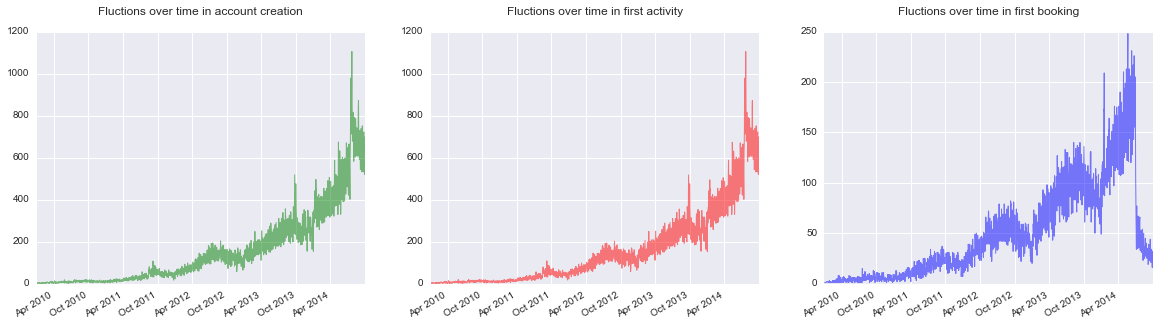

In [66]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
colours = ['g', 'r', 'b']
vars = ['date_account_created', 'date_first_active', 'date_first_booking']
titles = ['account creation', 'first activity', 'first booking']
for i, var in enumerate(vars):
    users[var].value_counts().plot(ax=axes[i], alpha=0.5, legend=False, lw=1, c=colours[i], xlim=['2010-01-01','2014-09-30'])
    axes[i].set_title('Fluctions over time in %s\n' % titles[i])

In [61]:
train['date_account_created'] = pd.to_datetime(train.date_account_created)
train['date_first_booking'] = pd.to_datetime(train.date_first_booking)
train['date_first_active'] = pd.to_datetime((train.timestamp_first_active // 1000000), format='%Y%m%d')

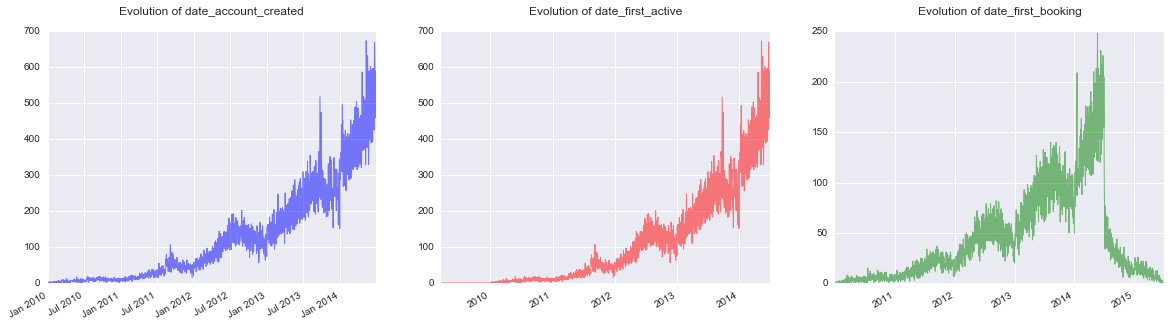

In [62]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
colours = ['b', 'r', 'g']
vars = ['date_account_created', 'date_first_active', 'date_first_booking']
titles = ['date_account_created', 'date_first_active', 'date_first_booking']
for i, var in enumerate(vars):
    train[var].value_counts().plot(ax=axes[i], alpha=0.5, legend=False, lw=1, c=colours[i])
    axes[i].set_title('Evolution of %s\n' % titles[i])

In [72]:
users['num_account_created'] = pd.to_numeric(users.date_account_created)
users['num_first_active'] = pd.to_numeric(users.date_first_active)
users[['num_account_created', 'num_first_active']].corr()

,num_account_created,num_first_active
num_account_created,1.000000,0.999479
num_first_active,0.999479,1.000000


In [85]:
users['num_account_created'] = pd.to_numeric(users.date_account_created)
users['num_first_active'] = pd.to_numeric(users.date_first_active)
users['num_first_booking'] = pd.to_numeric(users.date_first_booking)

print users[['num_account_created', 'num_first_active']].corr()
print
print users[['num_account_created', 'num_first_booking']].corr()

                     num_account_created  num_first_active
num_account_created             1.000000          0.999479
num_first_active                0.999479          1.000000

                     num_account_created  num_first_booking
num_account_created             1.000000           0.968063
num_first_booking               0.968063           1.000000


In [73]:
users.head(20)

,affiliate_channel,affiliate_provider,age,country_destination,date_account_created,date_first_booking,first_affiliate_tracked,first_browser,first_device_type,gender,id,language,signup_app,signup_flow,signup_method,timestamp_first_active,date_first_active,num_account_created,num_first_booking,num_first_active
0,direct,direct,NaN,NDF,2010-06-28,NaT,untracked,Chrome,Mac Desktop,-unknown-,gxn3p5htnn,en,Web,0,facebook,20090319043255,2009-03-19,1277683200000000000,NaN,1237420800000000000
1,seo,google,38,NDF,2011-05-25,NaT,untracked,Chrome,Mac Desktop,MALE,820tgsjxq7,en,Web,0,facebook,20090523174809,2009-05-23,1306281600000000000,NaN,1243036800000000000
2,direct,direct,56,US,2010-09-28,2010-08-02,untracked,IE,Windows Desktop,FEMALE,4ft3gnwmtx,en,Web,3,basic,20090609231247,2009-06-09,1285632000000000000,1.280707e+18,1244505600000000000
3,direct,direct,42,other,2011-12-05,2012-09-08,untracked,Firefox,Mac Desktop,FEMALE,bjjt8pjhuk,en,Web,0,facebook,20091031060129,2009-10-31,1323043200000000000,1.347062e+18,1256947200000000000
4,direct,direct,41,US,2010-09-14,2010-02-18,untracked,Chrome,Mac Desktop,-unknown-,87mebub9p4,en,Web,0,basic,20091208061105,2009-12-08,1284422400000000000,1.266451e+18,1260230400000000000
5,other,other,NaN,US,2010-01-01,2010-01-02,omg,Chrome,Mac Desktop,-unknown-,osr2jwljor,en,Web,0,basic,20100101215619,2010-01-01,1262304000000000000,1.262390e+18,1262304000000000000
6,other,craigslist,46,US,2010-01-02,2010-01-05,untracked,Safari,Mac Desktop,FEMALE,lsw9q7uk0j,en,Web,0,basic,20100102012558,2010-01-02,1262390400000000000,1.262650e+18,1262390400000000000
7,direct,direct,47,US,2010-01-03,2010-01-13,omg,Safari,Mac Desktop,FEMALE,0d01nltbrs,en,Web,0,basic,20100103191905,2010-01-03,1262476800000000000,1.263341e+18,1262476800000000000
8,other,craigslist,50,US,2010-01-04,2010-07-29,untracked,Safari,Mac Desktop,FEMALE,a1vcnhxeij,en,Web,0,basic,20100104004211,2010-01-04,1262563200000000000,1.280362e+18,1262563200000000000
9,other,craigslist,46,US,2010-01-04,2010-01-04,omg,Firefox,Mac Desktop,-unknown-,6uh8zyj2gn,en,Web,0,basic,20100104023758,2010-01-04,1262563200000000000,1.262563e+18,1262563200000000000


C:\Miniconda\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  if __name__ == '__main__':


{'boxes': [<matplotlib.lines.Line2D at 0x3a000d30>,
 'caps': [<matplotlib.lines.Line2D at 0x3a00fa58>,
 'fliers': [<matplotlib.lines.Line2D at 0x3a01bb00>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x3a01b588>,
 'whiskers': [<matplotlib.lines.Line2D at 0x34ffac18>,
  <matplotlib.lines.Line2D at 0x352e5f60>]}

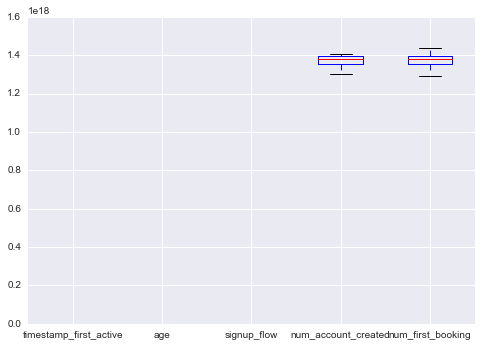

In [77]:
train.boxplot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000034FD0358>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000000221A7DD8>]], dtype=object)

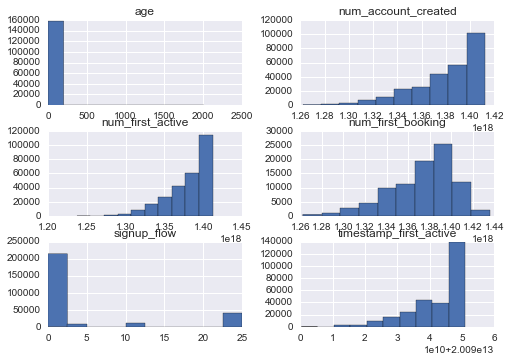

In [76]:
users.hist()

In [43]:
train.groupby(users.date_account_created.year).count()

AttributeError: 'Series' object has no attribute 'year'

In [23]:
print users.age.describe()
print
print sum(users.age>100)
print sum(users.age<18)

count    158681.000000
mean         47.145310
std         142.629468
min           1.000000
25%          28.000000
50%          33.000000
75%          42.000000
max        2014.000000
Name: age, dtype: float64

In [ ]:
test['timestamp_first_active'] = pd.to_datetime(test['timestamp_first_active'], format='%Y%m%d%H%M%S')
pd.to_datetime(train_df.timestamp_first_active//1000000, format='%Y%m%d')

In [25]:
g = sns.FacetGrid(students, hue="gender", palette="Set1", size=6)
g.map(plt.scatter, "gpa", "computer", s=250, linewidth=0.65,
  edgecolor="white")


NameError: name 'students' is not defined

In [ ]:
.astype('category').cat.codes
g = sns.FacetGrid(users, hue="gender", palette="Set1", size=6)
g.map(plt.scatter, "age", "affiliate_provider", s=250, linewidth=0.65, edgecolor="white")
g.add_legend()

***
# Scrap

In [ ]:
sdfgsdfg

In [ ]:
# categorical training data by country
bar_order = ['NDF','US','other','FR','IT','GB','ES','CA','DE','NL','AU','PT']
cat_vars = ['gender','first_device_type']

ctab = pd.crosstab([train[var]], train.country_destination).apply(lambda x: x/x.sum(), axis=1)
ctab

In [ ]:
gender = demographics[['country_destination','gender','population_in_thousands']].groupby(['country_destination','gender']).sum().unstack()
gender.reset_index(inplace=True)
gender.columns = ['country_destination', 'female', 'male']
gender['pop_in_thousands'] = gender['female'] + gender['male']
gender['pop_proportion'] = gender['pop_in_thousands'] / gender['pop_in_thousands'].sum()
gender.sort_values('pop_proportion', ascending=False)

In [ ]:
country_visits = pd.merge(gender, countries, how='left', on='country_destination')
country_visits.drop(['female','male','pop_proportion','lat_destination','lng_destination'], axis=1, inplace=True)
g = sns.PairGrid(country_visits)
g.map(plt.scatter);

In [ ]:
#age['age_num'] = age['age_bucket'].map(lambda x: int(x[:str.find(x,'-')]))
#country_demographics['gender_num'] = country_demographics['gender'].astype('category').cat.codes
#age['age_group'] = pd.cut(age['age_num'], 4, labels=["quarter-life","mid-life","3-quarter-life","full-life"])
sort_order = ['100+','95-99','90-94','85-89','80-84','75-79','70-74','65-69','60-64','55-59','50-54','45-49','40-44','35-39','30-34','25-29','20-24','15-19','10-14','5-9','0-4']

#age.drop(['age_bucket'], axis=1, inplace=True)
#age = age.groupby(['country_destination','age_group']).sum().reset_index()
#age = age.pivot(index='country_destination', columns='age_group', values='population_in_thousands').reset_index()

In [ ]:
# compare gender distributions within destination countries
# it's too hard to make out all 10 countries with this graphic, so I'm splitting them in two.

# 6 European Union Countries
list_eu = ['FR', 'ES', 'IT', 'PT', 'NL','DE']
dest_eu = demographics[demographics['country_destination'].isin(list_eu)]
g = sns.FacetGrid(dest_eu, col="country_destination", row="gender", sharex=False) 
g = g.map(plt.hist, "population_in_thousands")

# 4 Countries outside of the European Union
list_rest = ['US', 'CA', 'GB', 'AU']
dest_rest = demographics[demographics['country_destination'].isin(list_rest)]

g = sns.FacetGrid(dest_rest, col="country_destination", row="gender", size=3, aspect=1, sharex=False) 
g = g.map(plt.hist, "population_in_thousands")

In [ ]:
#demographics['age_num'] = demographics['age_bucket'].map(lambda x: int(x[:str.find(x,'-')]))
list_nonus = ['FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU']
dest_nonus = demographics[demographics['country_destination'].isin(list_nonus)]

sns.violinplot(x='country_destination', y='population_in_thousands', hue='gender', data=dest_nonus,
               split=True, inner='stick', palette='Set3');